# QSVM aplicado a um problema de classificação altamente complexo

Elaborado por:
- Equipe Qast - Beer Quantum Challenge (Ambev+QB) 2021

Neste notebook:

- Observamos a alta performance do Kernel quântico em problemas de classificação extremamente complexos, i.e. em casos onde a atribuição de classes {1, -1} aparenta ser praticamente aleatória.

- Mostramos também a incapacidade dos kernels clássicos mais comuns (implementados na biblioteca scikit-learn) em classificar tais dados. 

### 0. Importar bibliotecas

In [54]:
#general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#qiskit imports
from qiskit import Aer, execute, BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

#scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from qiskit_machine_learning.kernels import QuantumKernel

#others
from mlxtend.plotting import plot_decision_regions


### 2. Gerar dataset

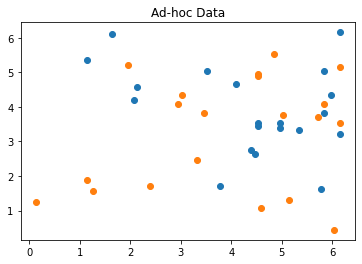

In [75]:
#Dataset sintético fornecido pelo Qiskit
from qiskit.ml.datasets import ad_hoc_data, sample_ad_hoc_data

feature_dim = 2

#200 instâncias de treino, 100 de teste
sample_total, training_input, test_input, class_labels = ad_hoc_data(
    training_size=20, 
    test_size=10,
    n=feature_dim,
    gap=0.2,
    plot_data=True
)
extra_test_data = sample_ad_hoc_data(sample_total, 10, n=feature_dim)
datapoints, class_to_label = split_dataset_to_data_and_labels(extra_test_data)

A fronteira de decisão necessária em $\mathbb{R}^2$ para realizar esta classifação é extremamente complexa

In [42]:
# # Import packages to visualize the classifer
# from matplotlib.colors import ListedColormap
# import matplotlib.pyplot as plt
# import warnings

# # Import packages to do the classifying
# import numpy as np
# from sklearn.svm import SVC

# # Create Dataset
# np.random.seed(0)
# X_xor = np.random.randn(200, 2)
# y_xor = np.logical_xor(X_xor[:, 0] > 0,
#                        X_xor[:, 1] > 0)
# y_xor = np.where(y_xor, 1, -1)

# fig = plt.figure(figsize=(10,10))
# plt.scatter(X_xor[y_xor == 1, 0],
#             X_xor[y_xor == 1, 1],
#             c='b', marker='x',
#             label='1')
# plt.scatter(X_xor[y_xor == -1, 0],
#             X_xor[y_xor == -1, 1],
#             c='r',
#             marker='s',
#             label='-1')

# plt.xlim([-3, 3])
# plt.ylim([-3, 3])
# plt.legend(loc='best')
# plt.tight_layout()
# plt.show()

### 3. Implementar Kernel quântico

In [124]:
shots = 10e03
feature_dim = 2
seed = 1234

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='circular')
qsvm = QSVM(feature_map, training_input, test_input, datapoints[0])

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)




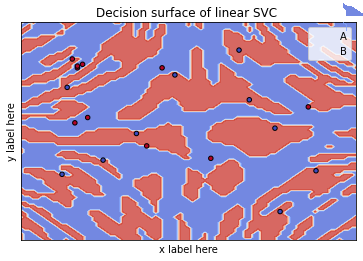

In [118]:

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# model = svm.SVC(kernel='linear')
# clf = model.fit(X, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Superfícies de decisão com Kernel quântico')
# Set-up grid for plotting.

X = np.concatenate([test_input['A'], test_input['B']], axis = 0) 
X0, X1 = X[:, 0], X[:, 1]
y = np.array([[0]*len(test_input['A']) + [1]*len(test_input['B'])]).ravel()
xx, yy = make_meshgrid(X0, X1, h = 0.1)

plot_contours(ax, qsvm, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('x1')
ax.set_xlabel('x0')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

#Pode levar minutos para executar

Testing success ratio: 100.0%

Prediction from datapoints set:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  success rate: 100.0%


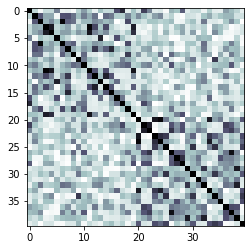

In [130]:
print(f'Testing success ratio: {100*result["testing_accuracy"]}%')
print()
print('Prediction from datapoints set:')
print(f'  ground truth: {map_label_to_class_name(datapoints[1], qsvm.label_to_class)}')
print(f'  prediction:   {result["predicted_classes"]}')
predicted_labels = result["predicted_labels"]
print(f'  success rate: {100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)}%')

kernel_matrix = result['kernel_matrix_training']
plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r');

### 3. Implementar Kernel clássico (rbf)

In [132]:
csvm = SklearnSVM(training_input, test_input, datapoints[0])
result_classical = csvm.run()

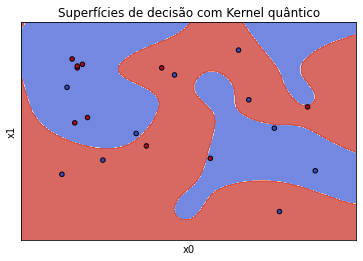

In [135]:

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# model = svm.SVC(kernel='linear')
# clf = model.fit(X, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Superfícies de decisão com Kernel quântico')
# Set-up grid for plotting.

X = np.concatenate([test_input['A'], test_input['B']], axis = 0) 
X0, X1 = X[:, 0], X[:, 1]
y = np.array([[0]*len(test_input['A']) + [1]*len(test_input['B'])]).ravel()
xx, yy = make_meshgrid(X0, X1, h = 0.02)

plot_contours(ax, csvm, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('x1')
ax.set_xlabel('x0')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

#Pode levar minutos para executar

Testing success ratio: 35.0%

Prediction from datapoints set:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['B', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'B', 'B', 'A', 'A', 'A', 'B', 'A', 'B']
  success rate: 45.0%


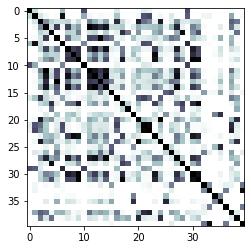

In [129]:
from qiskit.aqua.algorithms import SklearnSVM

print(f'Testing success ratio: {100*result_classical["testing_accuracy"]}%')
print()
print('Prediction from datapoints set:')
print(f'  ground truth: {map_label_to_class_name(datapoints[1], qsvm.label_to_class)}')
print(f'  prediction:   {result_classical["predicted_classes"]}')
predicted_labels = result_classical["predicted_labels"]
print(f'  success rate: {100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)}%')

kernel_matrix = result_classical['kernel_matrix_training']
plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper', cmap='bone_r');
